# Contrôle de systèmes dynamiques

- [Problématique générale](#PbGeneral)
- [Modélisation de systèmes dynamiques: les représentations d'état](#RepEtat)
- [Commande boucle ouverte et boucle fermée](#BOBF)
- [Contrôleur Proportionnel Intégral Dérivé (PID)](#PID)
- [Observateurs](#Obs)
- [Saturations](#Sat)

Les parties sur le contrôleur PID et les observateurs sont tirées du livre édité en 2008 par Denis Dochain et intitulé "Automatic Control of Bioprocesses".

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
# from IPython.html.widgets import interact, fixed
import scipy.integrate as scint
from matplotlib import patches as pat

## <a name="PbGeneral">Problèmatique générale</a>

### Objectif

L'objectif principal de l'automatique ou de la théorie du contrôle est d'imposer un comportement dynamique spécifique à un système en jouant sur les commandes disponibles: on dit alors que l'on commande ou contrôle le système.

<u>Exemples de comportements recherchés</u>:
- amener une quantité à atteindre une valeur désirée (régulation). Exemple: le chauffage
- stabilisation ou déstabilisation d'un système instable/stable. Exemple: lutte contre la prolifération d'insectes ravageurs
- poursuite d'une trajectoire. Exemple: missile

En plus de l'objectif à atteindre, il faut aussi respecter certaines contraintes.

<u>Exemples de contraintes</u>
- saturation de la commande. Exemple: débit maximum autorisé
- temps de réponse rapide
- peu d'oscillations
- minimisation de la consommation énergétique

### Comportement entrées/sorties

Quand on souhaite contrôler un système, on s'intéresse en fait à son comportement entrées/sorties, ce que l'on représente généralement de la manière suivante:

![Figure1](./images/SystemeEntreeSortie.jpg)

où:
- $u=(u_1,u_2,...,u_m)^T$ sont les entrées (vecteur), que l'on appelle aussi "actionneurs" ou "commandes"
- $y=(y_1,y_2,...,y_p)^T$ sont les sorties (vecteur)


### Design d'une loi de commande

Contrôler un système d'entrées $u$ et de sorties $y$ revient à chercher quelles entrées appliquer au système pour que les sorties se comportent comme on le souhaite.

> L'expression de $u$ est appelée **loi de commande**.

Il existe de nombreuses techniques permettant d'obtenir ces lois de commande. Certaines d'entre elles sont basées sur le modèle du système. 

## <a name="RepEtat">Modélisation de systèmes dynamiques: les représentations d'état</a>
Les systèmes étudiés peuvent être décrits par des modèles de types différents (EDO, EDP, modèles stochastiques, ...) qui sont fonction de la nature même du système, mais également de l'objectif de la modélisation (analyse, simulation, contrôle, etc.).  On s'intéresse ici aux systèmes dynamiques pouvant être décrits par un nombre fini d'équations différentielles ordinaires du premier ordre, c'est à dire des systèmes dits 'différentiels', de la forme:


\begin{equation}
 \left\{
\begin{array}{rcl}
 \dot{x_1} & = & f_1(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\dot{x_2} & = & f_2(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\vdots & = & \vdots \\
\dot{x_n} & = & f_n(x_1,x_2,...,x_n,u_1,u_2,...,u_m),
\end{array}
\right.
\end{equation}

où $\dot{x_i}$ représente la dérivée de la variable $x_i$ par rapport au temps $t$, aussi notée $\frac{dx_i}{dt}$. On ajoute à ce système une condition initiale  $x_0=(x_1(t_0), x_2(t_0), ... , x_n(t_0))^T$ et les sorties sont exprimées par une relation de la forme suivante:

\begin{equation}
 \left\{
\begin{array}{rcl}
{y_1} & = & h_1(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
{y_2} & = & h_2(x_1,x_2,...,x_n,u_1,u_2,...,u_m)\\
\vdots & = & \vdots \\
{y_p} & = & h_p(x_1,x_2,...,x_n,u_1,u_2,...,u_m).
\end{array}
\right.
\end{equation}

De manière plus concise, on écrira, pour $x_0$ donné:

<a name="RepEtatNL"> \begin{equation}
(M_1)\,\left\{
\begin{array}{rcl}
 \dot{x}&=&f(x,u)\\
y&=&h(x,u)
\end{array}
\right.
\end{equation}</a>
avec  $x=(x_1,x_2,...,x_n)^T,\,u=(u_1,u_2,...,u_m)^T,\,y=(y_1,y_2,...,y_p)^T,$ $f=(f_1,f_2,...,f_n)^T$ et $h=(h_1,h_2,...,h_p)^T$.


![Figure2](./images/SystemeDiff.jpg)
_Figure 2. Système différentiel d'entrées $u$ et de sorties $y$_

**Terminologie**
* le modèle [$(M_1)$](#RepEtatNL) est appelé **modèle d'état** ou **représentation d'état**.
* $x(t)\in \mathbb{R}^n$ est le vecteur des **variables d'état**: à un instant $t$ donné, $x(t)$ caractérise entièrement le système. En effet, la connaissance de $x(t)$ et la donnée des entrées $u$ sur l'intervalle $[t,T]$ suffisent à déterminer, via le système [$(M_1)$](#RepEtatNL), l'évolution de $x$ sur l'intervalle $[t,T]$. On peut dire que l'état d'un système à un instant $t$ représente la mémoire minimale du passé nécessaire à la détermination du futur.
* $u(t)\in \mathbb{R}^m$ est le vecteur des **entrées** ou encore **commandes**. Elles représentent l'influence du monde extérieur sur le système considéré. C'est via ces variables que l'on va pouvoir chercher à contrôler le système.
* $y(t)\in \mathbb{R}^p$ est le vecteur des **sorties**.

> **Remarque**
> * $x$, $y$ et $u$ sont des fonctions du temps, à valeurs respectivement dans $\mathbb{R}^n$, $\mathbb{R}^p$ et $\mathbb{R}^m$. La dépendance en temps sera parfois marquée explicitement, et parfois omise.
> * Etant donnée une condition initiale $x_0=x(t_0)$, et pour une entrée $u$ donnée, la solution $x(t)$ pour $t\geqslant t_0$ de [$(M_1)$](#RepEtatNL) est appelée **trajectoire** du système. On suppose qu'une telle trajectoire existe toujours, est unique et continue.
> * Un même système admet une infinité de représentations d'état, chacune associée à un choix de variables d'état.
> * Le choix des variables d'état est arbitraire. Cependant, en fonction de l'objectif de la modélisation, certains choix peuvent s'avérer plus judicieux que d'autres (maintien de la signification physique des variables par exemple...).
> * Le nombre minimal de variables d'états nécessaires à la caractérisation du système correspond à l'**ordre du système**.
> * Lorsque l'entrée $u$ du système peut être librement choisie, on dit que le système est **commandé**, car on peut contrôler l'allure de la trajectoire $x$ en jouant sur le choix de $u$.


### Cas linéaire
Un cas particulier de modèles d'état sont les modèles d'état linéaires, c'est à dire des modèles de la forme:

<a name="RepEtatLin">
\begin{eqnarray}
 (M_2)\,\left\{
\begin{array}{rcl}
 \dot{x}&=&Ax+Bu,\\
y&=&Cx+Du,
\end{array}
\right.
\end{eqnarray}
</a>

avec $A\in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n \times m}$, $C\in \mathbb{R}^{p \times n}$ et $D \in \mathbb{R}^{p \times m}$.

C'est une classe de modèles importante, car plus simple à étudier que les modèles non linéaires et pour laquelle de nombreux outils (d'analyse, de commande, etc...) ont été developpés.

### Cas non linéaire
Les outils développés pour les modèles linéaires peuvent être également utilisés dans le cas non linéaire, après linéarisation autour d'un point d'équilibre du modèle considéré.


En effet, soit $\bar{x}$ un point d'équilibre de [$(M_1)$](#RepEtatNL) pour un $\bar{u}$ donné (c'est à dire un point $\bar{x}$ tel que $f(\bar{x},\bar{u})=0$), et $B$ une boule ouverte de $\mathbb{R}^n \times \mathbb{R}^p$ centrée en $(\bar{x},\bar{u})$.
On suppose $f: \mathbb{R}^n \times \mathbb{R}^p \mapsto \mathbb{R}^n$ de classe $\mathcal{C}^1$ sur $\bar{B}$, c'est à dire dérivable par rapport à $x_i$ et $u_j$ pour tout $i=1:n,\, j=1:m$ et de dérivées partielles continues. La formule de Taylor à l'ordre $1$ nous donne alors, pour tout $(\delta x, \delta u)$ tel que $(\bar{x}+\delta x,\bar{u}+\delta u) \in B$:

\begin{equation}
 f(\bar{x}+\delta x,\bar{u}+\delta u)=f(\bar{x},\bar{u})+J_{f,x}(\bar{x},\bar{u})\delta x +J_{f,u}(\bar{x},\bar{u})\delta u+R_1(\delta x , \delta u),
\end{equation}

où $J_{f,x}(\bar{x},\bar{u})$ est la matrice jacobienne de $x \mapsto f(x,u)$ en $(\bar{x},\bar{u})$, c'est à dire la matrice:

\begin{equation}
 J_{f,x}(\bar{x},\bar{u})=
\left[
\begin{array}{ccc}
 \partial_{x_1}f_1(\bar{x},\bar{u}) & ... & \partial_{x_n}f_1(\bar{x},\bar{u})\\
\vdots &  & \vdots \\
 \partial_{x_1}f_n(\bar{x},\bar{u}) & ... & \partial_{x_n}f_n(\bar{x},\bar{u})
\end{array}
\right] \in \mathbb{R}^{n\times n},
\end{equation}

$J_{f,u}(\bar{x},\bar{u})$ est la matrice jacobienne de $u \mapsto f(x,u)$ en $(\bar{x},\bar{u})$, c'est à dire la matrice:

\begin{equation}
 J_{f,u}(\bar{x},\bar{u})=
\left[
\begin{array}{ccc}
 \partial_{u_1}f_1(\bar{x},\bar{u}) & ... & \partial_{u_m}f_1(\bar{x},\bar{u})\\
\vdots &  & \vdots \\
 \partial_{u_1}f_n(\bar{x},\bar{u}) & ... & \partial_{u_m}f_n(\bar{x},\bar{u})
\end{array}
\right]\in \mathbb{R}^{n\times m},
\end{equation}

et $R_1(\delta x , \delta u)$ est un 'reste', qui est négligeable devant $\lVert (\delta x,\delta u)  \lVert$, ce que l'on note également $R_1(\delta x , \delta u)=o(\lVert (\delta x,\delta u) \lVert)$, c'est à dire:

\begin{equation}
 \lim_{\lVert (\delta x,\delta u) \lVert \rightarrow 0} \frac{R_1(\delta x,\delta u)}{\lVert (\delta x,\delta u) \lVert}=0.
\end{equation}

Comme $f(\bar{x},u)=0$, et si l'on considère des $\delta x=x-\bar{X}$ et $\delta u=u-\bar{u}$ suffisamment petits, on obtient l'approximation linéaire du système, donnée par:

<a name="RE">
\begin{equation}
(M_3)\, \left\{
\begin{array}{rcl}
 \dot{\delta x}&=&J_{f,x}(\bar{x},\bar{u})\delta x+J_{f,u}(\bar{x},\bar{u})\delta u,\\
y&=&h(\bar{x}+\delta x,\bar{u}+\delta u).
\end{array}
\right.
\end{equation}
</a>

## <a name="BOBF">Commande boucle ouverte et boucle fermée</a>

Une fois que l'on s'est assuré de l'éxistence d'une commande $u$, on s'intéresse au problème de sa conception, de son design. Plusieurs stratégies de commande sont envisageables: on distingue notamment les lois de commande en boucle ouverte et en boucle fermée.

### Commande en boucle ouverte

> **Définition**  
> Une **commande en boucle ouverte** (ou **contrôle en boucle ouverte**) est une application $u:t\mapsto c(t)$ qui ne dépend pas de l'état ou de la sortie du système. Bien choisie, elle peut permettre de réaliser un objectif donné, à condition que le système soit bien connu, que le modèle soit fiable (voir parfait), et qu'il n'y ait aucun imprévu.

![Figure 6](./images/SystemeBO.jpg)
<a name="SystemeBO">Figure 6. Commande en boucle ouverte d'un système différentiel d'entrées $u$ et de sorties $y$</a>


> **Example d'un remplissage d'un réservoir pour l'irrigation**

> On s'intéresse au problème du remplissage d'un réservoir pour l'irrigation. Le réservoir doit être maintenu à un volume constant $V_c$, pour satisfaire les besoins en eau des agriculteurs qui viennent se servir dans ce réservoir. Pour remplir le réservoir, on peut pomper dans la nappe fréatique avec un débit variable $d$. A l'instant $t_0$, le réservoir est vide, et on souhaite le remplir.
>
> En notant $h$ la hauteur d'eau dans le réservoir et $b$ l'air de la base du réservoir, le volume s'écrit $V=b\times h$.
> En prenant $h$ comme variable d'état du système, on peut écrire le modèle de réservoir suivant:
>
> \begin{equation}
 \dot{V}=d \Longleftrightarrow \dot{h}=\frac{d}{b}.
\end{equation}

> Pour remplir le réservoir supposé vide, il suffit d'ouvrir le robinet (à fond si l'on souhaite que le réservoir se remplisse le plus vite possible) le temps nécessaire pour que le réservoir soit rempli. Si $d$ est le débit volumique, c'est à dire le volume d'eau fourni par unité de temps, et si on appelle $d_{max}$ la valeur maximale du débit, alors il faudra pomper dans la nappe fréatique pendant $T=\frac{V}{d_{max}}$. La commande boucle ouverte $u=d$ à appliquer est donc donnée par $u=d_{max} \mathrm{1}_{[t_0,t_0+\frac{V}{d_{max}}]}$.

In [2]:
plt.close('all') # ferme toutes les figures
# t est le temps courant
# T est la durée pendant laquelle on va pomper dans la nappe fréatique pour remplir le réservoir
# dmax est la valeur maximale du débit
# base est l'aire de la base carrée du réservoir
# cote est la longueur du côté de la base
# precip et conso sont des variables qui contiennent des données de précipitations et de consommation par les
#        les agriculteurs: cest variables ne sont pour l'instant pas utilisées
# x est la variable d'état du système, c'est à dire ici la hauteur d'eau dans le réservoir
# Vc est le volume que l'on veut atteindre dans le réservoir

# Loi de commande boucle ouverte
def fonction_u(t,T,dmax,base,Vc,precip,conso,x):
   
    # Si t<T, la commande vaut dmax, sinon elle vaut 0
    if type(t)==float: valu = (t<=T)*dmax # cas où l'entrée t de la fonction est un scalaire
    else: # cas où l'entrée t de la fonction est un vecteur
        valu = np.zeros(len(t))
        valu[t<=T] = dmax  
    return valu

# modèle du réservoir
def reservoir(x,t,T,dmax,base,precip,conso,Vc):
    # le modèle du réservoir est donné par dx/dt = u/base
    if np.fix(t)>len(precip)-1: dx = fonction_u(t,T,dmax,base,Vc,precip,conso,x)/base
    else : 
        dx = (fonction_u(t,T,dmax,base,Vc,precip,conso,x[0])+precip[int(np.fix(t))]+conso[int(np.fix(t))])/base
    return dx

def remplissage(pluie,arrosage):
    # pluie = 1 si on prend en compte les précipitations, 0 sinon
    # arrosage = 1 si on prend en compte la consommation des agriculteurs, 0 sinon
    
    # paramètres du modèles
    dmax  = 2.; cote  = 3.; base  = cote**2; Vmax  = 100; Vc = 90; T = Vc/dmax 
    
    # Prise en compte des précipitations pendant 1 an
    if pluie == 0: # si on ne considère pas les précipitations
        precip = np.zeros(365)
        tmax = min(T*1.5,365)
        nblinefig = 2
    else: # si on considère les précipitations, on va charger un fichier de données
        precip0 = np.loadtxt('data/precipitations.txt') # données en mm par jour (par m² de terrain)
        precip = 1e-3*precip0*base # conversion des données en m³ par jour
    
    # Prise en compte des arrosages
    conso = np.zeros(len(precip))
    if arrosage == 1: 
        # ajout de periodes dans l'année pendant lesquelles les agriculteurs utilisent de l'eau du réservoir
        conso[10:15] = -1
        conso[40:45] = -1
        conso[70:75] = -1
        conso[100:105] = -1
        conso[130:135] = -1
    
    # integration numerique de l'EDO
    if pluie + arrosage >0: 
        tmax=365 # temps maximal de simulation
        nblinefig = 4 # nombre de figure pour l'affichage
    temps = np.linspace(0,tmax,2000) # vecteur temps
    x0 = 0 # condition initiale
    h = scint.odeint(reservoir,x0,temps,args=(T,dmax,base,precip,conso,Vc)) # integration de l'équation
    u = fonction_u(temps,T,dmax,base,Vc,precip,conso,h) # re-calcul de la commande qui a été appliquée

    # tracé des solutions
    plt.figure(figsize = (10, 7))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((nblinefig,3),(0,0),rowspan=nblinefig)
    axes=plt.gca()
    axes.add_artist(pat.Rectangle((0, 0), cote, h[-1], color = 'blue'))
    plt.ylim([0,Vmax/base])
    plt.xlim([0,cote])
    plt.subplot2grid((nblinefig,3),(0,1),colspan=2)
    plt.plot(temps, h, color="red", linewidth="1")
    plt.plot(np.array([0,tmax]), np.array([Vc/base,Vc/base]), color="black", linewidth="1")
    plt.xlim([0,tmax])
    plt.ylim([0,Vmax/base])
    plt.title("Hauteur d'eau (m)")
    plt.subplot2grid((nblinefig,3),(1,1),colspan=2)
    plt.xlim([0,tmax])
    plt.plot(temps, u, color="red", linewidth="1")
    plt.ylim([-0.2,dmax*1.1])
    plt.title("débit d\'entrée ($m^3$ par jour)")
    if pluie + arrosage == 0:
        plt.xlabel("Temps (jour)")
        plt.xlim([0,tmax])
    else:
        plt.subplot2grid((nblinefig,3),(2,1),colspan=2)
        plt.plot(np.arange(365),precip0,color="red", linewidth="1")
        plt.xlim([0,tmax])
        plt.ylim([0,60])
        plt.title("Precipitations (mm) par jour")
        plt.subplot2grid((nblinefig,3),(3,1),colspan=2)
        plt.plot(np.arange(365),conso,color="red", linewidth="1")
        plt.xlim([0,tmax])
        plt.ylim([-1.2,0])
        plt.xlabel("Temps (jour)")
        plt.title("Consommation en $m^3$ par jour")
    plt.show()

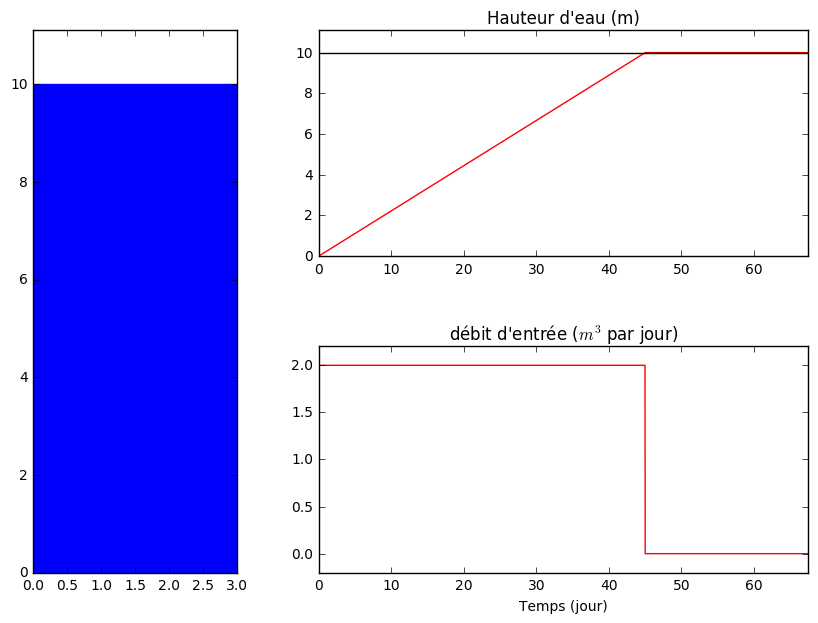

In [3]:
# Remplissage d'un réservoir par une loi de commande boucle ouverte, 
# sans prise en compte ni des précipitations ni de l'utilisation de l'eau par les agriculteurs
remplissage(0,0)


La commande boucle ouverte proposée permet de remplir le réservoir au volume souhaité, mais uniquement dans le cas où il n'y a aucun aléa, et où le système est parfaitement connu. Si on se place dans un cas plus réaliste, c'est à dire moins idéal, il faudra prendre en compte dans le système le fait qu'il peut pleuvoir (entrée supplémentaire du système), que des personnes vont utiliser l'eau de ce réservoir (sortie supplémentaire) et qu'il y a des imperfections dans le système qui font que la valeur de débit maximal n'est pas exactement égale $d_{\text{max}}$ et peut même varier légèrement dans le temps. Dans ces cas là, l'application de la commande en boucle ouverte ne conduira pas exatement au volume souhaité. C'est pourquoi on utilise des commandes en boucle fermée qui peuvent être robustes aux aléas, incertitudes et erreurs de modélisation.

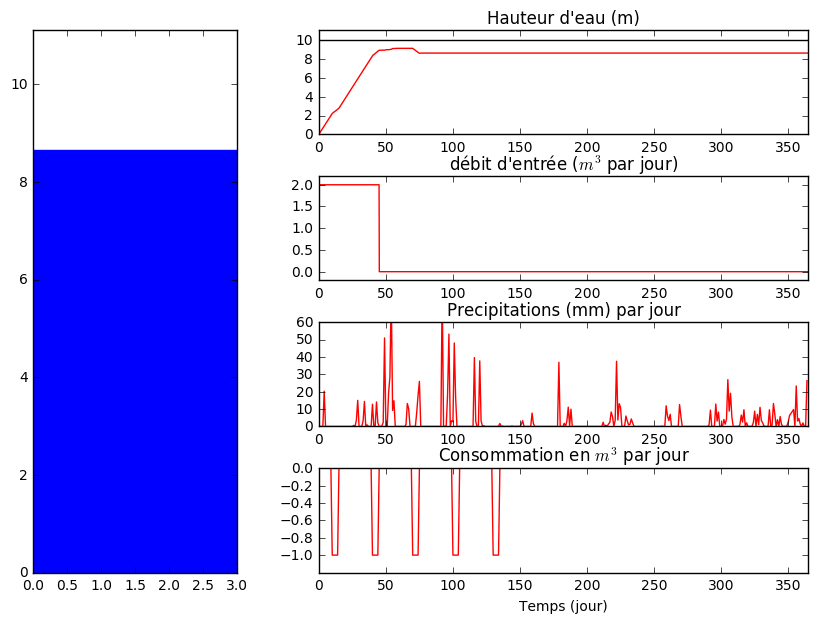

In [4]:
# Remplissage d'un réservoir par une loi de commande boucle ouverte, 
# AVEC prise en compte des précipitations et de l'utilisation de l'eau par les agriculteurs
plt.close('all') # close all figure
remplissage(1,1)

### Commande en boucle fermée ou rétroaction

> **Exemple du remplissage d'un réservoir pour l'irrigation**  
> On souhaite toujours que le réservoir soit maintenu à un volume constant $V_c$, pour satisfaire les besoins en eau des agriculteurs qui viennent se servir dans ce réservoir. Pour remplir le réservoir, on dispose toujours d'un accès à une nappe fréatique dans laquelle on peut pomper. Cependant, on souhaite maintenant tenir compte des précipitations, qui sont une seconde source (entrée) participant au remplissage du réservoir. La quantité d'eau de pluie qui tombe ne peut être contrôlée et n'est pas prévisible alors que la quantité d'eau pompée dans les nappes fréatiques peut être contrôlée via le débit de pompage $d$: ce sera l'entrée, ou commande, $u$ de notre système. 

> Dans ce cas, on s'aperçoit qu'il est impossible de proposer "à l'avance" une stratégie de pompage dans la nappe fréatique, puisque cela dépendra de la quantité de pluie tombée et de la consommation des agriculteurs! Il faut alors passer par une rétroaction, ou commande en boucle fermée, comme illustré dans la suite.   
 

> **Définition**  
> * Une **commande en boucle fermée** (ou **contrôle en boucle fermée**), aussi appelée **rétroaction** ou **feedback**, est une application $u:t\mapsto R(x(t),y(t))$ (voir figure [7](#SystemeBF)) choisie pour imposer un comportement dynamique au système d'état $x$
> * Si $u(t)=R(x(t))$ (respectivement $u(t)=R(y(t))$), on parlera de **retour d'état** (respectivement **retour de sortie**).
> * Si $R$ admet une expression analytique, on parlera de **retour** ou **commande statique**, 
> * Si $R$ n'est déterminée que via la résolution d'une équation dynamique, par exemple de la forme différentielle $\dot{u}=r(x,y,u)$, on parlera de **retour** ou **commande dynamique**. 

![Figure 7](./images/SystemeBF.jpg)
<a name="SystemeBF">Figure 7. Commande en boucle fermée (retour de sortie) d'un système différentiel d'entrées $u$ et de sorties $y$</a>

En utilisant une commande en boucle fermée, on décide d'appliquer une commande qui dépend de l'état courant (ou de la sortie) du système. On réajuste en fait la commande en fonction des informations que l'on récupère (via l'état ou la sortie) au cours du temps, ce qui permet de rectifier le comportement dans le cas d'évenements imprévus par exemple.

Souvent, on va avoir le schéma suivant:

1. On se donne une valeur à atteindre $y^\ast$ qu'on appelle **consigne**. Cette consigne peut être variable dans le temps.
2. A chaque pas de temps, on mesure la valeur de $y$
3. On compare $y$ et $y^\ast$
4. On ajuste la commande en fonction de la différence entre $y$ et $y^\ast$

![Structure générale loi de commande](./images/structureGeneraleControle.png)


> **Remarque**  
> La rétroaction est un phénomène qui se retrouve abondamment dans la nature, notamment lorsque des être vivants sont impliqués. Par exemple, la température du corps humain est constamment régulée: la transpiration (commande), qui dépend de la température extérieure (variable d'état mesurée), permet notamment cette régulation.  
> Le déplacement d'un animal comprend également des boucles de rétroactions: en fonctions des informations visuelles perçues (variables d'état mesurées) , le système nerveux central va envoyer des signaux (commande) aux muscles pour aller dans la bonne direction.

> **Exemple**: **Remplissage d'un réservoir pour l'irrigation (suite)**  
> Dans cet exemple, on comprend bien que la quantité d'eau que l'on va pomper dans la nappe fréatique va dépendre du volume d'eau déjà présent dans le réservoir. Si on prend comme variable d'état du système la hauteur d'eau dans le réservoir, on va donc faire un retour d'état.
> On suppose que l'on peut mesurer la hauteur d'eau $h$ dans le réservoir et que l'on connait l'air de la base $b$ du réservoir, de sorte que le volume soit directement déduit de la hauteur d'eau mesurée par la relation $V=b\times h$. Pendant le remplissage, on va donc avoir une équation d'état de la forme:
> \begin{equation}
 \dot{h}=\frac{d+p-c}{b},
\end{equation}
> où $d$ est le débit de pompage dans la nappe fréatique, $p$ est le débit d'entrée dû aux précipitations et $c$ est le débit de sortie dû à la consommation des agriculteurs.  

> Une loi de commande boucle fermée que l'on peut proposer est la suivante:
> \begin{equation}
 d=\alpha\,b(h_c- h)
\end{equation}
où $h_c=\frac{V_c}{b}$ et $\alpha>0$.
> En supposant que la mesure de la hauteur soit exacte, on a alors une dynamique du système en boucle fermée donnée par:
> \begin{equation}
 \dot{h}=\alpha(h_c-h)+\frac{p-c}{b}.
\end{equation}
> Si $p$ et $c$ sont ponctuelles et de valeurs pas trop grandes, alors $h$ va toujours tenter de se rapprocher de $h_c$.
> En fait, $p$ et $c$ peuvent être considérées comme des perturbations du système $\dot{h}=\alpha(h_c-h)$ qui est une équation d'un système du premier ordre telle que $h(t) \underset{t \rightarrow \infty}{\longrightarrow} h_c$.

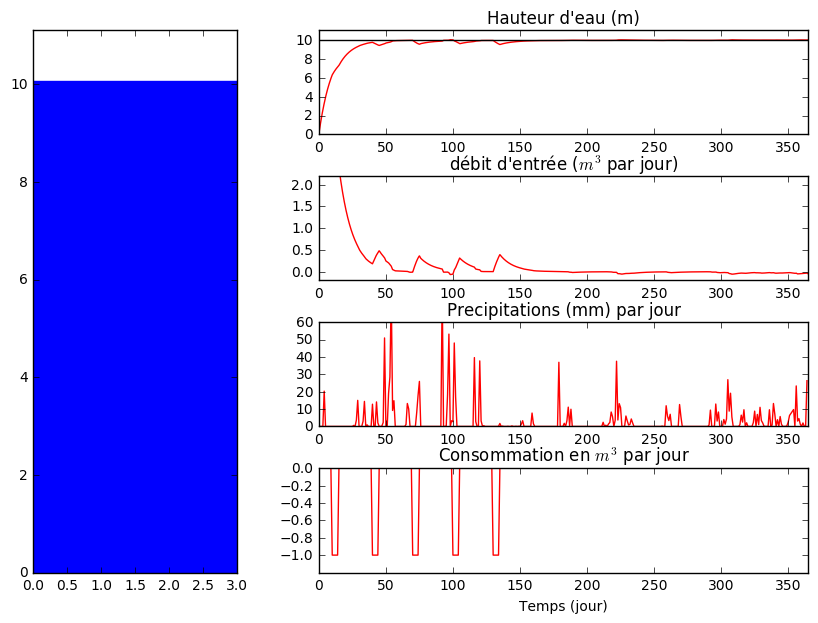

In [34]:
# Remplissage d'un réservoir par une loi de commande boucle fermée
# AVEC prise en compte ni des précipitations ni de l'utilisation de l'eau par les agriculteurs

plt.close('all') # close all figure
def fonction_u(t,T,dmax,base,Vc,precip,conso,x):
    coeffalpha=0.1
    if type(t)==float:
        valu = base*coeffalpha*(Vc/base-x)
    else:
        valu=base*coeffalpha*(Vc/base-x)
    return valu

remplissage(1,1)

### Quelques lois de commande boucle fermée classiques

Notons $y^m(t)$ la mesure de $y(t)$ à l'instant $t$. Voici deux lois de commande classiquement appliquées:

1. Commande "bang-bang" ou "tout ou rien":

$$ u(t)=\left\{
\begin{array}{c}
 u_{max}\text{ if }y^\ast-y^m(t)>0\\
 u_{min}\text{ if }y^\ast-y^m(t)\leqslant 0
\end{array}
\right.$$

2. Commande proportionnelle intégrale dérivée (PID)

$$ u(t)=u_c+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds+K_d\frac{d(y^\ast-y^m)}{dt}(t)$$

## <a name="PID">Contrôleur Proportionnel Intégral Dérivé (PID)</a>

La commande proportionnelle intégrale dérivée (PID) est, comme son nom l'indique, composée de 3 termes:
- un terme proportionnel à l'erreur $y^\ast-y^m$
- un terme proportionnel à l'intégral de l'erreur $y^\ast-y^m$
- et un terme proportionnel à la dérivée de l'erreur $y^\ast-y^m$

$$ u(t)=u_c+\underbrace{K_p(y^\ast-y^m(t))}_{\text{proportionnel}}+\underbrace{K_i\int_0^t(y^\ast-y^m(s))ds}_{\text{intégral}}+\underbrace{K_d\frac{d(y^\ast-y^m)}{dt}(t)}_{\text{dérivé}} $$

Nous allons illustrer ses performances sur un exemple concret.


### Exemple : Croissance d'une population dans un réacteur continu

On va s'intéresser à l'exemple de la croissance d'une population de micro-organismes que l'on notera $B$ (pour biomasse) sur un substrat noté $S$ dans un réacteur continu (c'est à dire à volume constant et alimenté en continu) et parfaitement mélangé. Cette réaction peut être schématiquement représentée de la manière suivante:

$$ S \underset{B}{\longrightarrow} B$$

la présence du $B$ sous la flèche signifiant que $B$ est un catalyseur de sa propre croissance (la vitesse de la réaction, qui est le taux de croissance de la population va donc dépendre de $B$). On supposera que le taux de croissance $\mu(S)$ de ces micro-organismes suit une loi de Haldane:

$$ \mu(S)=\frac{\mu^\ast S}{K_S+S+\frac{S^2}{K_I}}$$

Cette fonction admet un maximum en $S=\sqrt{K_sK_I}$ valant $\mu_{max}=\frac{\mu^\ast}{1+2\sqrt{\frac{K_S}{K_I}}}$

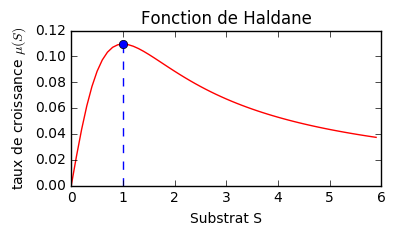

In [35]:
S= np.arange(0,6,0.1)
muast = 2.3; KS = 10; KI = 0.1;
mu=muast*S/(KS+S+S**2/KI)
Smax=np.sqrt(KS*KI)
mumax=muast*Smax/(KS+Smax+Smax**2/KI)
plt.figure(figsize = (4, 2))
plt.plot(S,mu,'r')
plt.plot(Smax*np.array([1,1]),np.array([0,mumax]),'b--')
plt.plot(Smax,mumax,'bo')
plt.xlabel('Substrat S')
plt.ylabel('taux de croissance $\mu(S)$')
plt.title('Fonction de Haldane')
plt.show()

On notera $Q$ le débit d'alimentation du réacteur (égal au débit de soutirage) et $V$ le volume constant du réacteur.

Un modèle de ce système est donné par:

$$
\boxed{
\left\{
\begin{array}{crl}
\frac{dB}{dt}= & \mu(S)B &-\frac{Q}{V}B\\
\frac{dS}{dt}= & -k\mu(S)B&+\frac{Q}{V}(S_0-S)  \\
\end{array}
\right.}
$$

> **Problème**: on cherche à contrôler la concentration $S$ de substrat dans le réacteur en jouant sur la commande $Q$.
> On note $S^\ast$ la valeur de la concentration en sucre que l'on souhaite atteindre. 

### Loi de commande boucle ouverte

Avant de tester un commande PID, on va regarder ce que donne la commande boucle ouverte.

Trouver la loi de commande boucle ouverte du problème consiste à trouver la valeur $Q^\ast$ de $Q$ qui, si elle est appliquée au système, amènera la concentration en sucre $S$ à la valeur $S^\ast$.

Autrement dit, on cherche la valeur $Q^\ast$ de $Q$ telle que $S^\ast$ (et la valeur de $B$ correspondante) est un point d'équilibre stable du système.

Avant de chercher cette valeur $Q^\ast$, on va d'abord se poser la question suivante:

> **Question**: Quelles sont les valeurs $S^\ast$ que l'on peut atteindre avec une loi de commande boucle ouverte (c'est à dire avec une valeur de $Q$ constante et positive)?

Répondre à cette question revient à calculer les points d'équilibre du système qui sont stables. On va donc chercher dans un premier temps l'ensemble des points d'équilibre, c'est à dire les valeurs de $S$ et $B$ telles que:

$$ \left\{
\begin{array}{rl}
(\mu(S) -\frac{Q}{V})B &=& 0\\
-k\mu(S)B+\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right. $$

En supposant que $Q>0$ (donc non nul) on a:

$$\left\{ \begin{array}{rl}
(\mu(S) -\frac{Q}{V})B &=& 0\\
-k\mu(S)B+\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right.
\Longleftrightarrow \left\{
\begin{array}{rl}
B &=& 0\\
\frac{Q}{V}(S_0-S) &=& 0 \\
\end{array}\right.
\text{ ou }
\left\{
\begin{array}{rl}
\frac{Q}{V} &=& \mu(S)\\
\mu(S)(S_0-S-kB) &=& 0 \\
\end{array}\right. $$

$$ 
\Longleftrightarrow 
\left\{
\begin{array}{rl}
B &=& 0\\
S &=& S_0 \\
\end{array}\right.
\text{ ou } 
\left\{
\begin{array}{rl}
\mu(S) &=& \frac{Q}{V}\\
B&=& \frac{S_0-S}{k} \\
\end{array}\right. $$

Il nous faut donc encore résoudre l'équation $\mu(S)=\frac{Q}{V}$. En remplaçant $\mu(S)$ par son expression, on obtient l'équation suivante:

$$ \frac{\mu^\ast S}{K_S+S+\frac{S^2}{K_I}}=\frac{Q}{V} $$

qui, si on la multiplie par $K_S+S+\frac{S^2}{K_I}$ (qui est toujours strictement positif), et après réarrangement, donne:

$$ \frac{Q}{V}K_S+(\frac{Q}{V}-\mu^\ast) S+\frac{Q}{V}\frac{S^2}{K_I}=0.$$

On peut montrer que, pour $0 < Q < V \frac{\mu^\ast}{1+2\sqrt{\frac{K_S}{K_I}}}$
cette équation admet deux solutions (racines du polynôme en $S$) notées $S_1$ et $S_2$ telles que
$$0 ≤  S_1 ≤  \sqrt{K_SK_I} ≤  S_2$$.

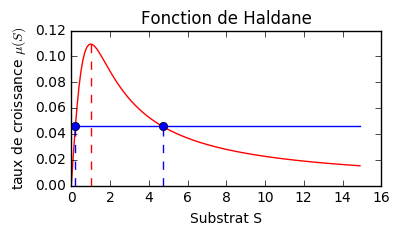

<function __main__.test>

In [36]:
def test(Q):
    r=np.roots(np.array([Q/(V*KI),Q/V-muast,Q*KS/V]))
    mur0 = muast*r[0]/(KS+r[0]+r[0]**2/KI)
    mur1 = muast*r[1]/(KS+r[1]+r[1]**2/KI)
    Smax = np.sqrt(KS*KI)
    mumax = muast*Smax/(KS+Smax+Smax**2/KI)
    S= np.arange(0,max(max(r),15),0.1)
    D=Q/V
    mu=muast*S/(KS+S+S**2/KI)
    plt.figure(figsize = (4, 2))
    plt.plot(S,mu,'r')
    plt.plot(np.array([0,S[-1]]),D*np.array([1,1]),'b')
    plt.plot(r[0]*np.array([1,1]),np.array([0,mur0]),'b--')
    plt.plot(r[0],mur0,'bo')
    plt.plot(r[1]*np.array([1,1]),np.array([0,mur1]),'b--')
    plt.plot(r[1],mur1,'bo')
    plt.plot(Smax*np.array([1,1]),np.array([0,mumax]),'r--')
    plt.xlabel('Substrat S')
    plt.ylabel('taux de croissance $\mu(S)$')
    plt.title('Fonction de Haldane')
    plt.show()

muast = 2.3; KS = 10; KI = 0.1;Qin = 0.01; V = 0.5;
Qmax = V*muast/(1+2*np.sqrt(KS/KI))
interact(test,Q=(0.001,Qmax,Qmax/10))

On a donc $3$ points d'équilibre qui sont:

- $E_0=(B,S) = (0,S_0)$ : ce point d'équilibre correspond au lessivage, c'est à dire à la disparition totale de la population de micro-organismes
- $E_1=(B,S) = (\frac{S_0-S_1}{k},S_1)$ 
- $E_2=(B,S) = (\frac{S_0-S_2}{k},S_2)$ 

Si on s'intéresse maintenant à la stabilité (locale) de ces points d'équilibre, on peut montrer (admis) que:
- $E_0$ est stable si et seulement si $\frac{Q}{V}>\mu(S_0)$
- $E_1$ est stable 
- $E_2$ est instable

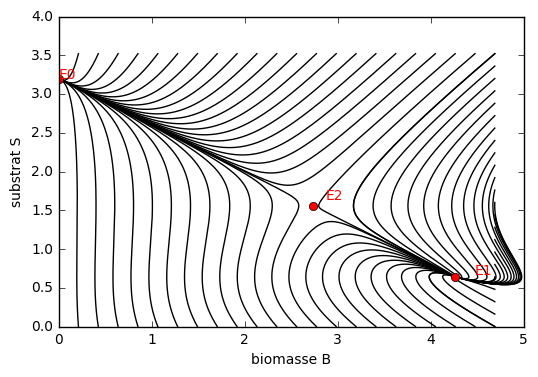

In [37]:
echelle  = np.linspace(0.3, 0.9, 5)
couleurs = plt.cm.winter(np.linspace(0.3, 1., len(echelle)))

muast = 2.3; KS = 10; KI = 0.1;Q = 0.05; V = 0.5; S0 = 3.2; coeffk = 0.6;

r=np.roots(np.array([Q/(V*KI),Q/V-muast,Q*KS/V])) 
Bmax=(max(S0-r)/coeffk)*1.1
Smax=max(max(r),S0)*1.1
tmax=200
temps = np.linspace(0,tmax,20000)

def reacteur(x,t,coeffk,muast,KS,KI,Q,V,S0):
    B = x[0] #biomass
    S = x[1] #substrat
    dx = np.zeros(2)
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -coeffk*mu*B+Q/V*(S0-S)
    return dx

for k in np.arange(4):
    nbinit = 22
    for l in np.arange(nbinit+1):
        x0 = np.zeros(2)
        if k == 0:
            x0[0]=0
            x0[1]= l*Smax/nbinit
        elif k==1:
            x0[0]=l*Bmax/nbinit
            x0[1]=Smax
        elif k==2:
            x0[0]=Bmax
            x0[1]=l*Smax/nbinit
        elif k==3:
            x0[0]=l*Bmax/nbinit
            x0[1]=0
            
        X = scint.odeint(reacteur,x0,temps,args=(coeffk,muast,KS,KI,Q,V,S0))
        plt.plot(X[:,0],X[:,1],'k')

plt.plot((S0-r[0])/coeffk,r[0],'ro')
plt.text((S0-r[0])/coeffk*1.05,r[0]*1.05,'E2',color='r')
plt.plot((S0-r[1])/coeffk,r[1],'ro')
plt.text((S0-r[1])/coeffk*1.05,r[1]*1.05,'E1',color='r')
plt.plot(0,S0,'ro')
plt.text(0,S0,'E0',color='r')
plt.xlabel('biomasse B')
plt.ylabel('substrat S')
plt.show()


En conclusion, on a montré que les seuls points d'équilibre atteignables avec une commande boucle ouverte sont $E_0$ et $E_1$. Comme $0 ≤  S_1 ≤  \sqrt{K_SK_I}$ les seules valeurs $S^\ast$ atteignables avec une commande boucle ouverte sont:

$$S^\ast \in\left[0,\sqrt{K_SK_I}\right]\cup \left\{S_0 \right\}$$

On retourne maintenant à la question de départ qui était:

> **Question**: Etant donnée une valeur atteignable $S^\ast$ de $S$, quelle est la valeur $Q^\ast$ de $Q$ telle que $S$ tende vers $S^\ast$?

Dans notre cas, on a vu que les points d'équilibre $E_1$ et $E_2$ étaient caractérisés par $\mu(S)=\frac{Q}{V}$.
Pour atteindre $S^\ast$ il faudra donc appliquer un débit $Q^\ast$ égal à:
$$Q^\ast=V \mu(S^\ast)$$

In [38]:
# Contrôle boucle ouverte de la culture bactérienne dans un réacteur continu
plt.close('all') # close all figure

def fonction_u(t,x,Sast,k,muast,KI,KS,V,SO,control_type,coeffcontrol):
    if control_type == 'BO':
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valu = Qast
        else: valu = np.ones(len(t))*Qast    
    return valu

def reacteur(x,t,k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb):
    B = x[0] #biomass
    S = x[1] #substrat
    Q = fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    dx = np.zeros(2)
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -k*mu*B+Q/V*(S0-S)
    return dx

def culture_cont(Sast,control_type,coeffcontrol,disturb):
    tmax = 150
    temps = np.linspace(0,tmax,2000) # vecteur temps

    k = 0.6; muast = 2.3; KS = 10; KI = 0.1; S0 = 3.2; B0 = 9; Qin = 0.01; V = 0.5; 
    
    # integration numerique de l'EDO
    if control_type in ['I','PI','PID']: x0 = np.array([B0,S0,0])
    else: x0 = np.array([B0,S0])
    x = scint.odeint(reacteur,x0,temps,args=(k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb))
    u = fonction_u(temps,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)

    plt.figure(figsize = (10, 3))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((1,2),(0,0))
    plt.plot(temps,x[:,0],'r',label='Biomasse')
    plt.plot(temps,x[:,1],'g',label='Substrat')
    plt.plot(np.array([0,temps[-1]]),np.array([Sast,Sast]),'g--',label='S*')
    plt.legend(); plt.xlabel('time (h)')
    
    plt.subplot2grid((1,2),(0,1))
    plt.plot(temps,u,'r',label='Debit')
    plt.legend(); plt.xlabel('time (h)')
    plt.show()

**Test 1**: Loi de commande en boucle ouverte, sans perturbation

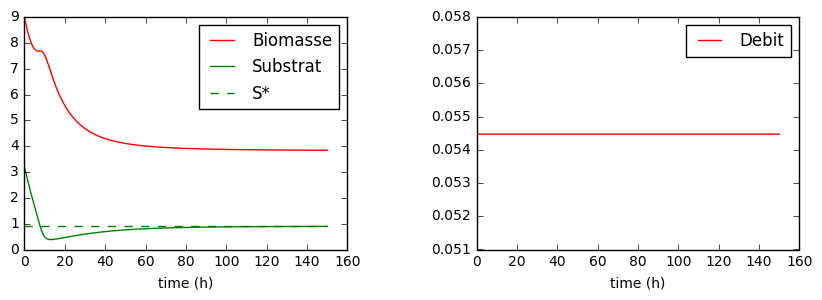

<function __main__.test>

In [10]:
def test(Sast):
    return culture_cont(Sast,'BO',0,0)
interact(test,Sast=(0,2,0.1))

On constate donc que, si on choisit une valeur de consigne $S^\ast$ atteignable, alors la loi de commande boucle ouverte permet bien de faire tendre la concentration en sucre vers cette valeur de consigne. 

Ce n'est par contre plus le cas si on choisit un $S^\ast>\sqrt{K_SK_I}$

Regardons maintenant si cette loi de commande est robuste aux perturbations.

Supposons que pour des raisons physiques, il y a une erreur entre le débit que l'on souhaite appliqué (et qui est donné par la loi de commande), et le débit qui est réellement appliqué.

$$ D_{réel}=D_{calc}(1+\delta)$$



**Test 2**: Loi de commande en boucle ouverte, AVEC perturbation 

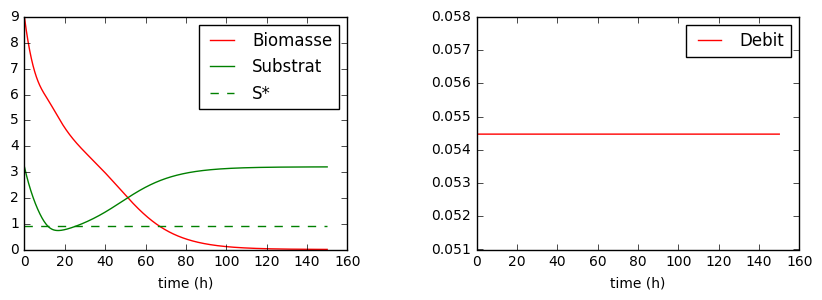

<function __main__.test>

In [11]:
def test(Sast,disturb):
    return culture_cont(Sast,'BO',0,disturb)
interact(test,Sast=(0,2,0.1),disturb=(0,0.4,0.01))

#### Limites de la boucle ouverte

On touche ici aux limites de la commande boucle ouverte.

- la commande boucle ouverte ne peut être utilisée que pour certaines valeurs de consignes
- cette commande n'est pas robuste aux perturbations

### Action proportionnelle

On va maintenant tester une loi de commande boucle fermée constituée d'un terme proportionnel à l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=u_c+K_p(y^\ast-y^m(t))$$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=V\mu(S^\ast)+K_p(S^\ast-S^m(t))$$

In [12]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu :  commande proportionnelle
def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO':
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valu = Qast
        else: valu = np.ones(len(t))*Qast
    elif control_type == 'P':
        kprop=coeffcontrol
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valS = x[1]
        else: valS = x[:,1]
        valu = Qast+kprop*(Sast-valS)    
    return valu

**Test**: Loi de commande en boucle fermée avec action proportionnelle, sans perturbation 

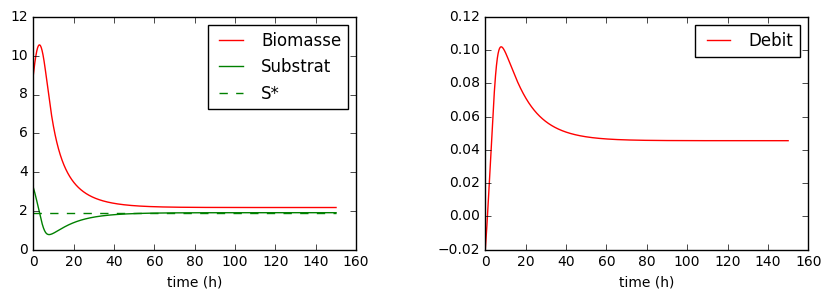

<function __main__.test>

In [13]:
def test(Sast,kprop):
    return culture_cont(Sast,'P',kprop,0)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01))

Comparé à la commande en boucle ouverte, on constate qu'avec la commande boucle fermée avec terme proportionnel, on peut atteindre des valeurs $S^\ast$ de $S$ qui étaient non atteignables avec la boucle ouverte.

Testons maintenant si cette commande est robuste aux perturbations.

**Test**: Loi de commande en boucle fermée avec action proportionnelle, AVEC perturbation

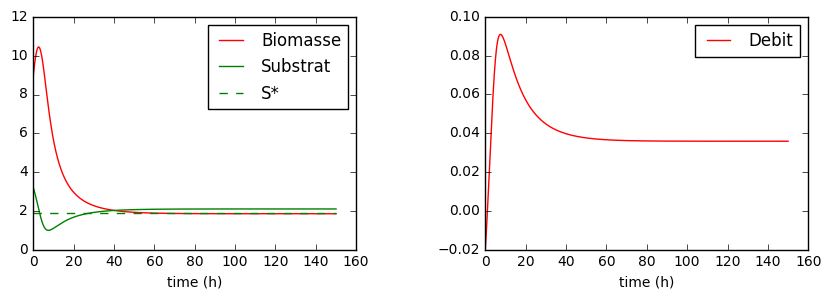

<function __main__.test>

In [14]:
def test(Sast,kprop,disturb):
    return culture_cont(Sast,'P',kprop,disturb)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01),disturb=(0,0.4,0.01))

On constate que la commande boucle fermée proportionnelle n'est pas robuste aux perturbations.

Rajoutons maintenant un terme intégral à cette loi de commande.

### Action intégrale

On va donc maintenant tester une loi de commande boucle fermée constitué d'un terme proportionnel à l'erreur et d'un terme proportionnel à l'intégrale de l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=u_c+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds$$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=V\mu(S^\ast)+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds$$

In [15]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu :  commande proportionnelle et intégrale

def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO':
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valu = Qast
        else: valu = np.ones(len(t))*Qast
    elif control_type == 'P':
        kprop=coeffcontrol
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valS = x[1]
        else: valS = x[:,1]
        valu = Qast+kprop*(Sast-valS)
    elif control_type == 'PI':
        kprop=coeffcontrol[0]
        kint=coeffcontrol[1]
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valint = x[2]; valS = x[1]
        else: valint = x[:,2]; valS = x[:,1]
        valu = Qast+kprop*(Sast-valS)+kint*valint    
    return valu

def reacteur(x,t,k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,disturb):
    B = x[0] #biomass
    S = x[1] #substrat
    
    Q = fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    
    if control_type in ['PI','PID']:
        dx = np.zeros(3)
        dx[2] = Sast-S
    else: dx = np.zeros(2)
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -k*mu*B+Q/V*(S0-S)
    return dx

**Test**: Loi de commande en boucle fermée avec actions proportionnelle et intégrale, sans perturbation

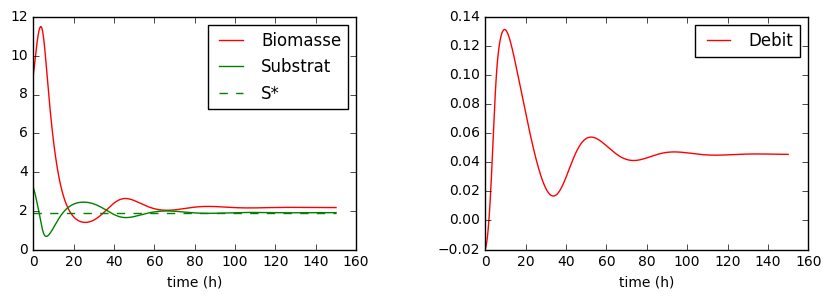

<function __main__.test>

In [16]:
def test(Sast,kprop,kint):
    return culture_cont(Sast,'PI',np.array([kprop,kint]),0)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01),kint=(0,0.02,0.001))

**Test**: Loi de commande en boucle fermée avec actions proportionnelle et intégrale, AVEC perturbation

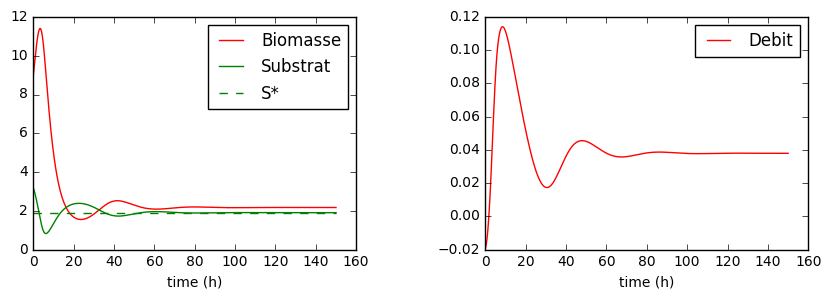

<function __main__.test>

In [17]:
def test(Sast,kprop,kint,disturb):
    return culture_cont(Sast,'PI',np.array([kprop,kint]),disturb)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01),kint=(0,0.02,0.001),disturb=(0,0.4,0.01))

On remarque que, en ajoutant le terme intégral dans la commande, cela permet d'annuler l'erreur que l'on faisait avec les lois de commande boucle ouverte ou boucle fermée proportionnelle.

Les lois de commande Proportionnelle Intégrale sont donc robustes aux perturbations!

**Remarque**
D'un point de vue pratique, pour calculer le terme intégral de la loi de commande:

$$I=\int_0^t(y^\ast-y^m(s))ds$$

on va résoudre l'équation différentielle:

$$ \frac{dI}{dt}=K_i(y^\ast-y^m)$$

### Action Dérivée

On peut également rajouter un terme dérivée dans la loi de commande boucle fermée. On obtient alors la loi de commande proportionnelle intégrale dérivée (PID) avec un terme proportionnel à l'erreur, un terme proportionnel à l'intégrale de l'erreur et un terme proportionnel à la dérivée de l'erreur, c'est à dire une loi de commande de la forme:

$$ u(t)=u_c+K_p(y^\ast-y^m(t))+K_i\int_0^t(y^\ast-y^m(s))ds+K_d\frac{d(y^\ast-y^m)}{dt}$$

Dans le cas de notre exemple, cela correspondant à la loi de commande:

$$ Q(t)=V\mu(S^\ast)+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds+K_d \frac{d(S^\ast-S^m(s))}{dt}$$

In [18]:
# Contrôle boucle fermée de la culture bactérienne dans un réacteur continu: commande proportionnelle intégrale dérivée (PID)

def fonction_u(t,x,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol):
    if control_type == 'BO':
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valu = Qast
        else: valu = np.ones(len(t))*Qast
    elif control_type == 'P':
        kprop=coeffcontrol
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valS = x[1]
        else: valS = x[:,1]
        valu = Qast+kprop*(Sast-valS)
    elif control_type == 'PI':
        kprop=coeffcontrol[0]
        kint=coeffcontrol[1]
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valint = x[2]; valS = x[1]
        else: valint = x[:,2]; valS = x[:,1]
        valu = Qast+kprop*(Sast-valS)+kint*valint
    elif control_type == 'PID':
        kprop=coeffcontrol[0]
        kint=coeffcontrol[1]
        kderiv=coeffcontrol[2]
        Qast=muast*Sast/(KS+Sast+Sast**2/KI)*V
        if type(t)==float: valint = x[2]; valS = x[1]; valB=x[0]
        else: valint = x[:,2]; valS = x[:,1]; valB = x[:,0]
        mu = muast*valS/(KS+valS+valS**2/KI)
        valu = (Qast+kprop*(Sast-valS)+kint*valint+kderiv*k*mu*valB)/(1+kderiv/V*(S0-valS))
    return valu

**Test**: Loi de commande en boucle fermée avec actions proportionnelle intégrale et dérivée (PID), AVEC perturbations

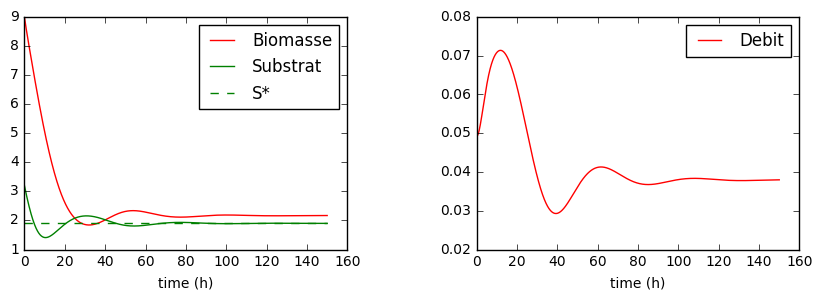

<function __main__.test>

In [19]:
def test(Sast,kprop,kint,kderiv,disturb):
    return culture_cont(Sast,'PID',np.array([kprop,kint,kderiv]),disturb)
interact(test,Sast=(0,4,0.1),kprop=(0,0.1,0.01),kint=(0,0.02,0.001),kderiv=(0,0.5,0.1),disturb=(0,0.4,0.01))

L'action dérivée du PID peut permettre d'accélérer la dynamique de la loi de commande boucle fermée. 

La loi de commande PID est très souvent utilisée dans l'industrie, souvent sous la forme PI dont les paramètres sont plus faciles à choisir.

## <a name="Obs">Observateurs</a>

Les lois de commande qui sont construites (PID ou autres types) dépendent de certaines variables du système (variables d'état, d'entrée ou de sortie). 

Par exemple, pour le contrôle de la concentration du susbtrat $S$ dans un réacteur continu, exemple que l'on a considéré précédemment, la commande PID:

$$ Q(t)=V\mu(S^\ast)+K_p(S^\ast-S^m(t))+K_i\int_0^t(S^\ast-S^m(s))ds+K_d \frac{d(S^\ast-S^m(s))}{dt}$$

dépend de la concentration de substrat ou plus exactement de sa mesure $S^m$.

Or, cette quantité n'est pas forcément mesurée, et d'autant moins en temps réel. Pour appliquer la commande, il va donc falloir que l'on estime la valeur de $S$. C'est ce que vont permettre de faire les observateurs.

Le principe de l'observateur est donné sur la figure suivante:

![Figure1](./images/Observateurs.png)


**Définition**: Un observateur pour le système:

$$\left\{
\begin{array}{rcl}
 \dot{x}&=&f(x,u)\\
y&=&h(x,u)
\end{array}
\right. 
$$

est un système d'équations de la forme:

$$ \left\{
\begin{array}{rcl}
 \dot{z}&=&\hat{f}(z,y,u)\\
\hat{x}&=&\hat{h}(z,y,u)
\end{array}
\right. $$

tel que $\hat{x}$ donne une "bonne" estimation de $x$, ce que l'on peut traduire par:

$$ \lim_{t\rightarrow \infty} \left\Vert x-\hat{x}  \right\Vert = 0$$

Parmi tous les observateurs possibles, on va chercher ceux qui ont les deux propriétés intéressantes suivantes:

1. l'observateur doit converger plus rapidement que la dynamique du système
2. si $\hat{x}(0)=x(0)$ alors $\hat{x}(t)=x(t)$ pour tout $t>0$, ce qui veut dire que si on part de la bonne valeur de l'état, alors on doit pouvoir estimer parfaitement l'état aux temps suivants

Une forme d'observateur couramment utilisée, qui peut avoir les propriétés recherchées, est la suivante:

$$ \left\{
\begin{array}{rcl}
 \dot{z}&=&f(z,u)+C\left[h(z,u)-y\right]\\
\hat{x}&=&z
\end{array}
\right. $$

L'équation en $z$ est constitué d'un premier terme qui copie la dynamique du système à observer, et d'un second terme correctif qui dépend de l'erreur entre l'estimation donnée par l'observateur et la sortie (mesurée) $y$ du système.

> **Exemple: Croissance d'une population dans un réacteur continu (suite)**

> Un modèle du système est donné par:
> 
> $$
\left\{
\begin{array}{crl}
\frac{dB}{dt}= & \mu(S)B &-\frac{Q}{V}B\\
\frac{dS}{dt}= & -k\mu(S)B&+\frac{Q}{V}(S_0-S)  \\
\end{array}
\right.
$$
> Supposons que l'on ne mesure que le dégagement de gaz représenté par la quantité $\mu(S)B$. Alors on a:
$$ y = \mu(S)B =: h(S,B)$$

> Un observateur du système est donné par:
$$
\left\{
\begin{array}{crl}
\frac{d\hat{B}}{dt}= & \mu(\hat{S})\hat{B} &-\frac{Q}{V}\hat{B}+C_1\left[\mu(\hat{S})\hat{B}-y\right]\\
\frac{d\hat{S}}{dt}= & -k\mu(\hat{S})\hat{B}&+\frac{Q}{V}(S_0-\hat{S})+C_2\left[\mu(\hat{S})\hat{B}-y\right]\\
\end{array}
\right.
$$

In [20]:
def reacteur_obs(x,t,k,muast,KS,KI,Qin,V,S0,Sast,control_type,coeffcontrol,obs,Cobs,disturb):
    B = x[0] #biomass
    S = x[1] #substrat
    
    if control_type in ['PI','PID']:
        indObs = 3
        Shat = x[indObs+1]
        dx = np.zeros(6)
        dx[2] = Sast-S
        dx[5] = Sast-Shat
    else: 
        dx = np.zeros(4)
        indObs = 2
    
    if obs == 0:
        xest = x[0:indObs]
    elif obs == 1:
        xest = x[indObs:]
         
    Q = fonction_u(t,xest,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
        
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -k*mu*B+Q/V*(S0-S)
    
    Bhat = x[indObs]
    Shat = x[indObs+1]
    muhat = muast*Shat/(KS+Shat+Shat**2/KI)
    dx[indObs] = muhat*Bhat-Q/V*Bhat+Cobs[0]*(muhat*Bhat-mu*B)
    dx[indObs+1] = -k*muhat*Bhat+Q/V*(S0-Shat)+Cobs[1]*(muhat*Bhat-mu*B)
    return dx

def culture_cont(Sast,control_type,coeffcontrol,obs,coeffobs,disturb):
    tmax = 100
    temps = np.linspace(0,tmax,2000) # vecteur temps

    k = 0.6; muast = 2.3; KS = 10; KI = 0.1; S0 = 3.2; B0 = 9; Qin = 0.01; V = 0.5;

    B0obs = coeffobs[0]
    S0obs = coeffobs[1]
    Cobs = coeffobs[2:]
    
    # integration numerique de l'EDO
    if control_type in ['PI','PID']: 
        x0 = np.array([B0,S0,0,B0obs,S0obs,0])
        indObs = 3
    else: 
        x0 = np.array([B0,S0,B0obs,S0obs])
        indObs = 2
    x = scint.odeint(reacteur_obs,x0,temps,args=(k,muast,KS,KI,Qin,V,S0,Sast, \
                                                 control_type,coeffcontrol,obs,Cobs,disturb))
    if obs == 0:
        u = fonction_u(temps,x[:,0:indObs],Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)
    elif obs == 1:
        u = fonction_u(temps,x[:,indObs:],Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)
        
    plt.figure(figsize = (10, 3))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((1,2),(0,0))
    plt.plot(temps,x[:,0],'r',label='Biomasse')
    plt.plot(temps,x[:,1],'g',label='Substrat')
    plt.plot(temps,x[:,indObs],'r--',label='Biomasse estimée')
    plt.plot(temps,x[:,indObs+1],'g--',label='Substrat estimé')
    plt.plot(np.array([0,temps[-1]]),np.array([Sast,Sast]),'k--',label='S*')
    plt.legend(); plt.xlabel('time (h)')
    
    plt.subplot2grid((1,2),(0,1))
    plt.plot(temps,u,'r',label='Debit')
    plt.legend(); plt.xlabel('time (h)')
    plt.show()

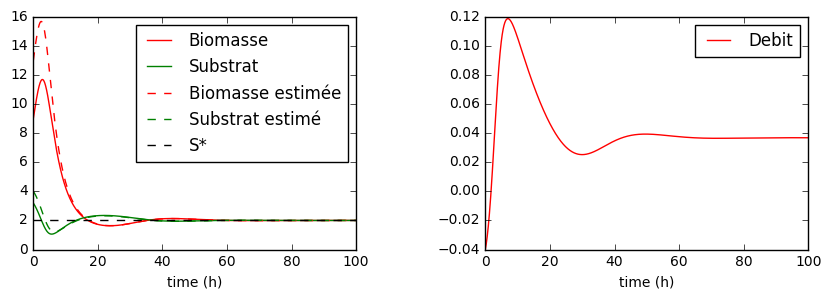

In [21]:
# Simulation sans utiliser les observations dans la loi de commande: on suppose l'état connu
culture_cont(2,'PI',np.array([0.07,0.01]),0,np.array([13,4,-2,0.1]),0.2)

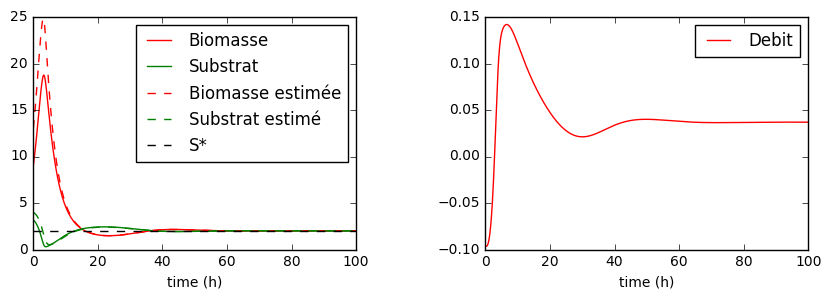

In [22]:
# Simulation en utilisant les observations dans la loi de commande
culture_cont(2,'PI',np.array([0.07,0.01]),1,np.array([13,4,-2,0.1]),0.2)

## <a name="Sat"> Saturations </a>

Dans le paragraphe précédent, on a vu que, lorsque certaines variables du système n'étaient pas mesurées, il était possible de les estimer grâce à un observateur.

Un autre problème que l'on peut rencontrer en pratique vient des saturations sur les commandes. En effet, pour des raisons souvent physiques, on ne peut pas appliquer n'importe quelle commande à notre système. Il y a en effet des limites physiques aux valeurs de commande, que l'on peut exprimer de la manière suivante:

$$ u_{min} ≤ u ≤ u_{max}$$



> **Exemple: Croissance d'une population dans un réacteur continu (suite)**
>
> Dans cet exemple la commande étant un débit d'entrée, celle-ci ne pourra pas être négative. Les limites physiques de la pompe impose également une valeur de débit maximale, que l'on notera $Q_{max}$ et que l'on prendra égale à $0.1 L/h$.
> On a donc:
> $$ 0 ≤ Q ≤ Q_{max}$$
> Or, on voit sur la figure précédente que la loi de commande que l'on a utilisée propose des valeurs de $Q$ négatives et supérieures à $Q_{max}$. C'est donc une loi de commande que l'on ne pourra pas appliquer telle qu'elle au système. 

Un première solution à ce problème consiste à appliquer une saturation à la commande calculée $u_{calc}$.

La valeur $u_{réelle}$ que l'on appliquera sera déterminée à partir de $u_{calc}$ de la manière suivante:

$$ u_{réelle} = \left\{ \begin{array}{ll} 
u_{min} & \text{si }u_{calc} ≤ u_{min}\\
u_{calc} & \text{si }u_{min} < u_{calc} < u_{max}\\
u_{max} & \text{si }u_{max} ≤ u_{calc}\\
\end{array}\right.$$

In [23]:
def reacteur_obs(x,t,k,muast,KS,KI,Qin,V,S0,Qmax,Sast,control_type,coeffcontrol,obs,Cobs,sat,coeffsat,disturb):
    B = x[0] #biomass
    S = x[1] #substrat
    
    if control_type in ['PI','PID']:
        indObs = 3
        Shat = x[indObs+1]
        dx = np.zeros(6)
        dx[2] = Sast-S
        dx[5] = Sast-Shat
    else: 
        dx = np.zeros(4)
        indObs = 2
    
    if obs == 0:
        xest = x[0:indObs]
    elif obs == 1:
        xest = x[indObs:]
         
    Q = fonction_u(t,xest,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    
    if sat == 1:
        if Q<0: Q=0
        elif Q>Qmax: Q=Qmax
        
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -k*mu*B+Q/V*(S0-S)
    
    Bhat = x[indObs]
    Shat = x[indObs+1]
    muhat = muast*Shat/(KS+Shat+Shat**2/KI)
    dx[indObs] = muhat*Bhat-Q/V*Bhat+Cobs[0]*(muhat*Bhat-mu*B)
    dx[indObs+1] = -k*muhat*Bhat+Q/V*(S0-Shat)+Cobs[1]*(muhat*Bhat-mu*B)
    return dx

def culture_cont(Sast,control_type,coeffcontrol,obs,coeffobs,sat,coeffsat,disturb):
    tmax = 100
    temps = np.linspace(0,tmax,2000) # vecteur temps

    k = 0.6; muast = 2.3; KS = 10; KI = 0.1; S0 = 3.2; B0 = 9; Qin = 0.01; V = 0.5; Qmax = 0.1;

    B0obs = coeffobs[0]
    S0obs = coeffobs[1]
    Cobs = coeffobs[2:]
    
    # integration numerique de l'EDO
    if control_type in ['PI','PID']: 
        x0 = np.array([B0,S0,0,B0obs,S0obs,0])
        indObs = 3
    else: 
        x0 = np.array([B0,S0,B0obs,S0obs])
        indObs = 2
    x = scint.odeint(reacteur_obs,x0,temps,args=(k,muast,KS,KI,Qin,V,S0,Qmax,Sast, \
                                                 control_type,coeffcontrol,obs,Cobs,sat,coeffsat,disturb))
    if obs == 0:
        u = fonction_u(temps,x[:,0:indObs],Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)
    elif obs == 1:
        u = fonction_u(temps,x[:,indObs:],Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)
        
    if sat > 0: u = (u<=0)*0+(0<u)*(u<Qmax)*u+(u>Qmax)*Qmax

    plt.figure(figsize = (10, 3))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot2grid((1,2),(0,0))
    plt.plot(temps,x[:,0],'r',label='Biomasse')
    plt.plot(temps,x[:,1],'g',label='Substrat')
    plt.plot(temps,x[:,indObs],'r--',label='Biomasse estimée')
    plt.plot(temps,x[:,indObs+1],'g--',label='Substrat estimé')
    plt.plot(np.array([0,temps[-1]]),np.array([Sast,Sast]),'k--',label='S*')
    plt.legend(); plt.xlabel('time (h)')
    
    plt.subplot2grid((1,2),(0,1))
    plt.plot(temps,u,'r',label='Debit')
    plt.legend(); plt.xlabel('time (h)')
    plt.show()

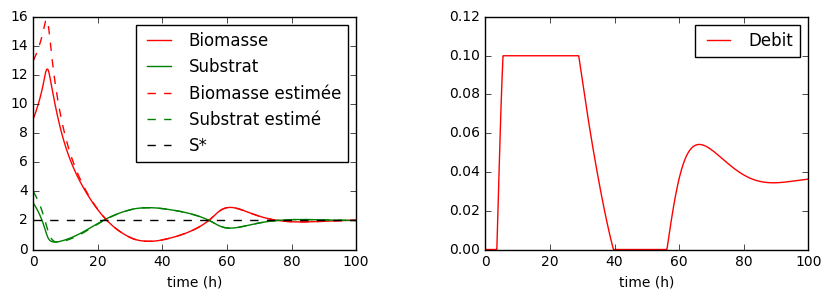

In [24]:
# Simulation avec loi de commande PI, observateur et saturation
culture_cont(2,'PI',np.array([0.07,0.01]),1,np.array([13,4,-2,0.1]),1,0,0.2)

Imposer une saturation sur une commande peut néanmoins dégrader fortement la dynamique du système en boucle fermée, voire carrément déstabiliser le système.
Cela est essentiellement dû au fait que lorsque la commande est saturée, le terme intégral continu de grossir car il continue d'intégrer l'erreur: on parle d'effet "wind-up".

** Méthode anti-windup **

Pour pallier ce problème, on utilise des techniques d'"anti-wind-up" qui consistent en fait à vider le terme intégral (c'est à dire le diminuer) lorsque la commande est saturée. Concrètement, au lieu de calculer le terme intégral 

$$I=\int_0^t(y^\ast-y^m(s))ds$$

comme présenté précédemment, c'est à dire en résolvant:

$$ \frac{dI}{dt}=K_i(y^\ast-y^m),$$

on va résoudre l'équation:

$$ \frac{dI}{dt}=K_i(y^\ast-y^m)+K_{aw}(u_{réel}-u_{calc})$$.

In [25]:
def reacteur_obs(x,t,k,muast,KS,KI,Qin,V,S0,Qmax,Sast,control_type,coeffcontrol,obs,Cobs,sat,coeffsat,disturb):
    B = x[0] #biomass
    S = x[1] #substrat
    
    if control_type in ['PI','PID']:
        indObs = 3
        Shat = x[indObs+1]
        dx = np.zeros(6)
        dx[2] = Sast-S
        dx[5] = Sast-Shat
    else: 
        dx = np.zeros(4)
        indObs = 2
    
    if obs == 0:
        xest = x[0:indObs]
    elif obs == 1:
        xest = x[indObs:]
         
    Q = fonction_u(t,xest,Sast,k,muast,KI,KS,V,S0,control_type,coeffcontrol)*(1+disturb)
    
    if sat == 1:
        if Q<0: Q=0
        elif Q>Qmax: Q=Qmax
    elif sat == 2:
        if Q<0: Qr=0
        elif Q>Qmax: Qr=Qmax
        else:
            Qr = Q
        if control_type in ['PI','PID']:
            dx[2] = Sast-S+coeffsat*(Qr-Q)
            dx[5] = Sast-Shat+coeffsat*(Qr-Q)
        Q = Qr
        
    mu = muast*S/(KS+S+S**2/KI)
    dx[0] = mu*B-Q/V*B
    dx[1] = -k*mu*B+Q/V*(S0-S)
    
    Bhat = x[indObs]
    Shat = x[indObs+1]
    muhat = muast*Shat/(KS+Shat+Shat**2/KI)
    dx[indObs] = muhat*Bhat-Q/V*Bhat+Cobs[0]*(muhat*Bhat-mu*B)
    dx[indObs+1] = -k*muhat*Bhat+Q/V*(S0-Shat)+Cobs[1]*(muhat*Bhat-mu*B)
    return dx

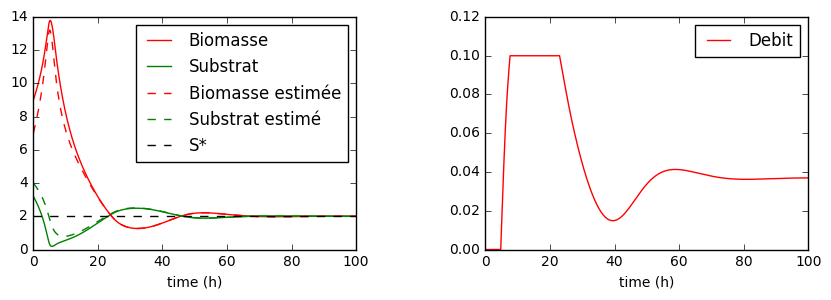

In [26]:
# Simulation avec loi de commande PI, observateur et saturation et anti-windup
culture_cont(2,'PI',np.array([0.07,0.01]),1,np.array([7,4,-2,0.1]),2,4,0.2)